In [1]:
import sympy as sp
import numpy as np
from IPython.display import display

#display(yourobject)

# Dedução das equações dinâmicas por Lagrange

## Introdução

In [2]:
sp.init_printing()

In [8]:
t = sp.Symbol("t", positive=True)

# Propriedades da cabeça
m_c, J_c = sp.symbols("m_c J_c", positive=True)
x_c = sp.Function("x_c", real=True)(t)
y_c = sp.Function("y_c", real=True)(t)
theta_c = sp.Function("theta_c", real=True)(t)

# Propriedades do torço
m_t, J_t, L_t = sp.symbols("m_t J_t L_t", positive=True)
x_t = sp.Function("x_t", real=True)(t)
y_t = sp.Function("y_t", real=True)(t)
theta_t = sp.Function("theta_t", real=True)(t)

# Propriedades dos membros inferiores
x_i = sp.Function("x_i", real=True)(t)
m_i = sp.Symbol("m_i", positive=True)

# Interação air bag-cabeça
k_ab, c_ab = sp.symbols("k_ab c_ab", positive=True)

# Propriedades do pescoço
## Deformação do pescoço
x_p = sp.Function("x_p", positive=True)(t)
L_p = sp.Symbol("L_p", positive=True)
## Mola linear
k_p, c_p = sp.symbols("k_p c_p", positive=True)
## Mola de torção
k_rp, c_rp = sp.symbols("k_rp c_rp", positive=True)

# Propriedades do cinto de segurança
k_s, c_s = sp.symbols("k_s c_s", positive=True)

# Propriedades do braço
k_b, c_b = sp.symbols("k_b c_b", positive=True)

# Interação air_bag-torso
k_ab, c_ab = sp.symbols("k_ab c_ab", positive=True)

# Ligamento torço-membros inferiores
k_ri, c_ri = sp.symbols("k_ri c_ri", positive=True)

# Interações de amortecimento dos membros inferiores
k_i, c_i = sp.symbols("k_i c_i", positive=True)

# Desaceleração do carro
a = sp.Function("a", real=True)(t)

g = sp.Symbol("g", positive=True)

| Parâmetro  | Unidade    |                      Explicação                      |
| ---------- | ---------- | :--------------------------------------------------: |
| $m_c$      | kg         |                   Massa da cabeça                    |
| $J_c$      | kg*m²      |             Momento de inércia da cabeça             |
| $x_c$      | m          |         Posição do centro de massa da cabeça         |
| $y_c$      | m          |         Posição do centro de massa da cabeça         |
| $\theta_c$ | rad        |                 Inclinação da cabeça                 |
| $m_t$      | kg         |                    Massa do torso                    |
| $J_t$      | kg*m²      |             Momento de inércia do torso              |
| $L_t$      | m          |  Distância do centro de massa do torso até o banco   |
| $x_t$      | m          |         Posição do centro de massa do torso          |
| $y_t$      | m          |         Posição do centro de massa do torso          |
| $\theta_t$ | rad        |                 Inclinação do torso                  |
| $x_i$      | m          |  Posição do centro de massa dos membros inferiores   |
| $m_i$      | kg         |             Massa dos membros inferiores             |
| $x_p$      | m          |                Deformação do pescoço                 |
| $L_p$      | m          |           Comprimento natural do pescoço             |
| $k_p$      | N/m        |        Propriedade elástica linear do pescoço        |
| $c_p$      | N*s/m      |        Propriedade viscosa linear do pescoço         |
| $k_{rp}$   | N*m        |        Constante da mola de torção do pescoço        |
| $c_{rp}$   | N\*s\*m    |    Constante do amortecedor de torção do pescoço     |
| $k_s$      | N/m        |          Propriedades do cinto de segurança          |
| $c_s$      | N*s/m      |          Propriedades do cinto de segurança          |
| $k_b$      | N/m        |                Propriedades do braço                 |
| $c_b$      | N*s/m      |                Propriedades do braço                 |
| $k_{ab}$   | N/m        |                 Interação do air bag                 |
| $c_{ab}$   | N*s/m      |                 Interação do air bag                 |
| $k_{ri}$   | N*m        |     Ligamento dos membros inferiores com o torso     |
| $c_{ri}$   | N\*s\*m    |     Ligamento dos membros inferiores com o torso     |
| $k_i$      | N/m        |  Interações de amortecimento dos membros inferiores  |
| $c_i$      | N*s/m      |  Interações de amortecimento dos membros inferiores  |

Muito bem, senhoras e senhores, iremos agora deduzir as equações dinâmicas para o nosso modelo de *crash test* utilizando o método de Lagrange. Garanto que será uma experiência intensa e engrandecedora. Não sei dizer se _de fato_ engrandecedora, mas certamente será intensa. No mais, confie na matemática e lá vamos nós

## Dedução de T (energia cinética)

$$T = \sum_{i \subset C} \cfrac{m_i*v_{gi}^2}{2} + \cfrac{J_i*\omega_i^2}{2}$$

Onde:

| Parâmetro  | Significado                              |
| ---------- | ---------------------------------------- |
| $C$        | conjunto de corpos de sistema            |
| $v_{gi}$   | velocidade do centro de massa do corpo i |
| $m_i$      | massa do corpo i                         |
| $J_i$      | momento de inércia do corpo i            |
| $\omega_i$ | velocidade angular do corpo i            |


In [44]:
class Corpo():
    def __init__(self, massa, mom_inercia, x, y, theta):
        self.massa        = massa
        self.mom_inercia  = mom_inercia
        
        self.x = x
        self.y = y
        self.theta = theta
        
        try:
            self.y_ponto = y.diff()
        except:
            self.y_ponto = 0
            
        try:
            self.x_ponto = x.diff()
        except:
            self.x_ponto = 0
            
        try:
            self.theta_ponto = theta.diff()
        except:
            self.theta_ponto = 0
            
        self.quad_vel_lin = self.x_ponto**2+self.y_ponto**2
        self.quad_vel_ang = self.theta_ponto**2
        
    def cinetica(self):
        return (self.massa*self.quad_vel_lin)/2 \
                + (self.mom_inercia*self.quad_vel_ang)/2
        
    def potencial(self, a_x, a_y):
        return self.massa*(a_x*self.x + a_y*self.y)
    
    def show(self):
        return (self.massa, self.quad_vel_lin, 
                self.mom_inercia, self.quad_vel_ang)

Corpos = [Corpo(m_c, J_c, x_c, y_c, theta_c),
          Corpo(m_t, J_t, x_t, y_t, theta_t),
          Corpo(m_i, 0, x_i, 0, 0)]

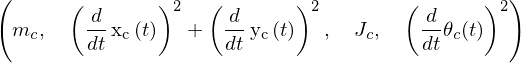

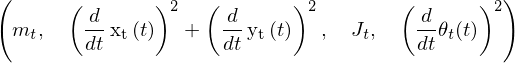

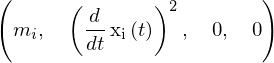

In [45]:
for corpo in Corpos:
    display(corpo.show())

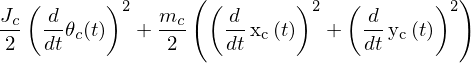

In [46]:
display(Corpos[0].cinetica())

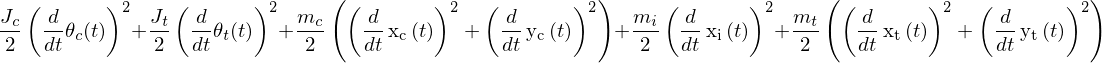

In [47]:
T = 0
for corpo in Corpos:
    T += corpo.cinetica()

display(T)

## Dedução de V (energia potencial)

$$V = \sum_{i \subset M} \cfrac{k_i*q_i^2}{2} + \sum_{i \subset C} m_i(x_i*a + y_i*g)$$

Onde:

| Parâmetro | Significado                               |
| --------- | ----------------------------------------- |
| $M$       | conjunto de molas do sistema              |
| $C$       | conjunto de corpos de sistema             |
| $k_i$     | constante elástica da mola i              |
| $q_i$     | coordenada de distenção da mola i         |
| $m_i$     | massa do corpo i                          |
| $x_i$     | coordenadas do centro de massa do corpo i |
| $y_i$     | coordenadas do centro de massa do corpo i |
| $g$       | aceleração da gravidade                   |
| $a$       | aceleração do carro                       |

In [48]:
class Mola:
    def __init__(self, k, c, q):
        self.k = k        
        self.c = c
        self.q = q
        
    def potencial(self):
        return (self.k*self.q**2)/2
    
    def dissipador(self):
        return (self.c*self.q.diff()**2)/2
    
Molas = [Mola(k_p, c_p, x_p),
         Mola(k_rp, c_rp, theta_c-theta_t),
         Mola(k_s + k_ab + k_b, c_s + c_ab + c_b, x_t),
         Mola(k_i, c_i, x_i),
         Mola(k_ri, c_ri, theta_t)]

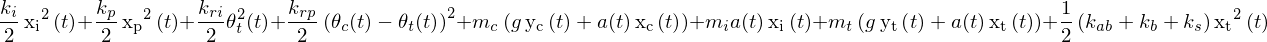

In [49]:
V = 0

for mola in Molas:
    V += mola.potencial()

for corpo in Corpos:
    V += corpo.potencial(a, g)

display(V)

## Dedução de D (dissipação de Rayleigh)

$$D = \sum_{i \subset A} \cfrac{c_i*q_i^2}{2} $$

Onde:

| Parâmetro | Significado                              |
| --------- | ---------------------------------------- |
| $A$       | conjunto de amortecedores do sistema     |
| $c_i$     | constante viscosa do amortecedor i       |
| $q_i$     | coordenada de distenção do amortecedor i |

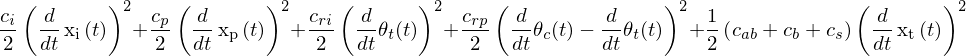

In [77]:
D = 0
for mola in Molas:
    D += mola.dissipador()

display(D)

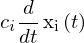

In [79]:
D.diff(x_i.diff())

Estamos tratando de um sistem de alta complexidade, portanto é essencial que nos atentemos aos conceitos envolvidos e a progressão lógica envolvida, uma vez que a complexidade das expressões finais tornam impossível sua revisão direta

Muito bem, dito isso, peço que analizem com carinho a lógica de cada etapa do processo, se preocupando em linhas gerais com o resultado final. No mais, essas são as funções equações dinâmicas que descrevem o nosso sistema. Antes de passarmos às simulações numéricas, podemos aplicar algumas restrições geométricas

## Simplificações geométricas

In [51]:
eqs = [(x_t, L_t/2*sp.sin(theta_t) + x_i), 
       (y_t, L_t/2*sp.cos(theta_t)), 
       (x_p, sp.sqrt((x_c-L_t*sp.sin(theta_t))**2 + (y_c-L_t*sp.cos(theta_t))**2) - L_p), 
       (theta_c, sp.atan((x_c-L_t*sp.sin(theta_t))/(y_c-L_t*sp.cos(theta_t))))]

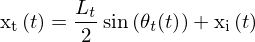

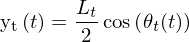

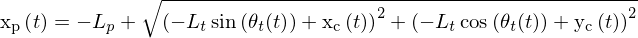

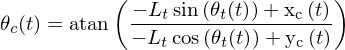

In [52]:
for eq in eqs:
    display(sp.Eq(*eq))

In [53]:
V_f = V
T_f = T
D_f = D

for eq in eqs:
    V_f = V_f.subs(*eq)
    T_f = T_f.subs(*eq)
    D_f = D_f.subs(*eq)

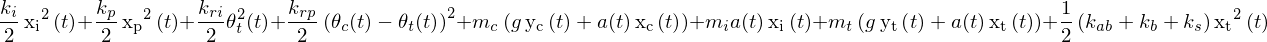

In [54]:
V

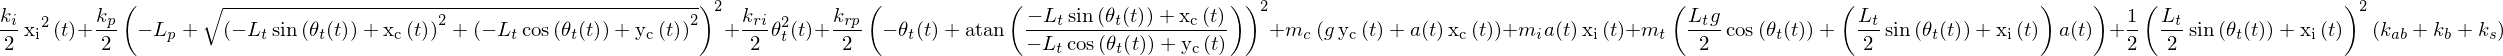

In [55]:
V_f

In [56]:
qs = [x_i, x_c, y_c, theta_t]

## Equação de Lagrange

In [80]:
lagrange = []
L_f = T_f - V_f
for q in qs:
    lagrange.append( L_f.diff( q.diff() ).diff(t) - L_f.diff(q) + D_f.diff( q.diff() ) )

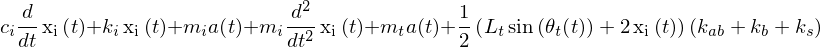

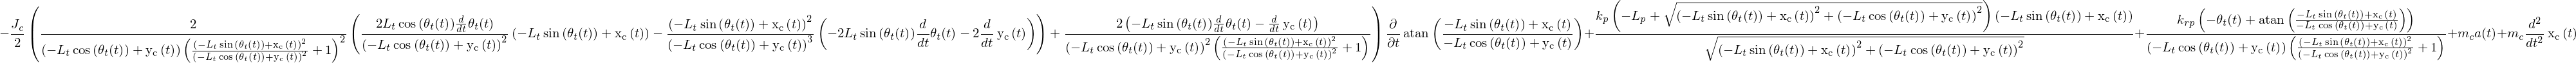

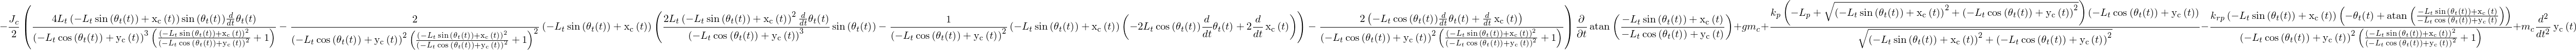

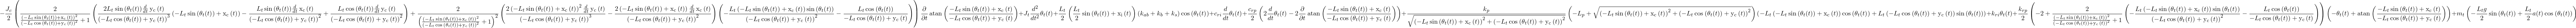

In [81]:
for eq in lagrange:
    display(eq)

In [67]:
qi = sp.Symbol("q_i")
l = sp.Symbol("L")(t, qi)
n = sp.Symbol("N")(t, qi)

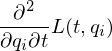

In [69]:
l.diff(qi).diff(t)